# CNN for medical-image classification (binary)
## author: Dr. Reynier Cruz Torres

## Data source and details:
https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

In [2]:
npixels = 128
do_training = True

In [3]:
gen = ImageDataGenerator(rescale=1./255,validation_split = 0.2)

In [4]:
train = gen.flow_from_directory('data/',
                               target_size = (npixels,npixels),
                               batch_size = 256,
                               class_mode = 'binary',
                               color_mode = 'grayscale',
                               shuffle = True,
                               seed = 42,
                               subset = 'training')

Found 3681 images belonging to 2 classes.


In [5]:
test = gen.flow_from_directory('data/',
                               target_size = (npixels,npixels),
                               batch_size = 8,
                               class_mode = 'binary',
                               color_mode = 'grayscale',
                               shuffle = True,
                               seed = 42,
                               subset = 'validation')

Found 919 images belonging to 2 classes.


In [6]:
classes = train.class_indices
classes

{'Brain_Tumor': 0, 'Healthy': 1}

### Defining model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dense, Dropout

model = Sequential()

model.add(InputLayer(input_shape=(npixels,npixels,1)))

model.add(Conv2D(filters=32,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())
model.add(Conv2D(filters=64,kernel_size=3, activation="relu", padding="same"))
model.add(MaxPool2D())

model.add(Flatten())

#model.add(Dense(128, activation='relu'))
#model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(rate=0.3))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 65536)             0         
                                                                 
 dropout (Dropout)           (None, 65536)             0

### Training model

In [8]:
if do_training:
    from tensorflow.keras.callbacks import EarlyStopping
    early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights = True)
    
    model.fit(train,verbose=1,callbacks = [early_stop],epochs=20,validation_data=(test))
    model.save('my_model.h5')
else:
    from tensorflow.keras.models import load_model
    model = load_model('my_model.h5')

Epoch 1/20


2023-01-10 11:53:32.706556: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


15/15 [==============================] - 18s 1s/step - loss: 0.6667 - accuracy: 0.6599 - val_loss: 2.1612 - val_accuracy: 0.4538
Epoch 2/20
15/15 [==============================] - 17s 1s/step - loss: 0.4568 - accuracy: 0.7832 - val_loss: 0.5050 - val_accuracy: 0.7519
Epoch 3/20
15/15 [==============================] - 17s 1s/step - loss: 0.3246 - accuracy: 0.8650 - val_loss: 0.4263 - val_accuracy: 0.8335
Epoch 4/20
15/15 [==============================] - 18s 1s/step - loss: 0.2106 - accuracy: 0.9253 - val_loss: 0.4715 - val_accuracy: 0.7214
Epoch 5/20
15/15 [==============================] - 18s 1s/step - loss: 0.1543 - accuracy: 0.9544 - val_loss: 0.3041 - val_accuracy: 0.9423
Epoch 6/20
15/15 [==============================] - 18s 1s/step - loss: 0.1106 - accuracy: 0.9726 - val_loss: 0.2867 - val_accuracy: 0.9619
Epoch 7/20
15/15 [==============================] - 20s 1s/step - loss: 0.0838 - accuracy: 0.9799 - val_loss: 0.2845 - val_accuracy: 0.9184
Epoch 8/20
15/15 [=============

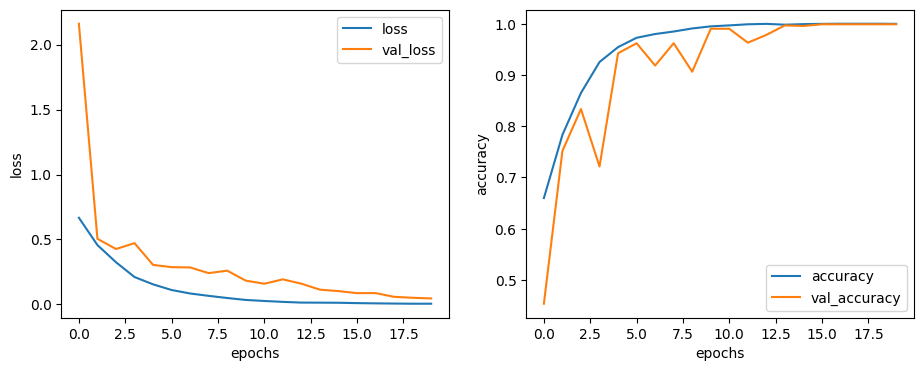

In [9]:
if do_training:
    fig, ax = plt.subplots(ncols=2,figsize=(11,4))
    history = pd.DataFrame(model.history.history)
    
    history[['loss','val_loss']].plot(ax=ax[0])
    ax[0].set_xlabel('epochs')
    ax[0].set_ylabel('loss')
    
    history[['accuracy','val_accuracy']].plot(ax=ax[1])
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('accuracy')

### Evaluating a few predictions by hand

Found 4600 images belonging to 2 classes.
1/1 [==============================] - 0s 71ms/step


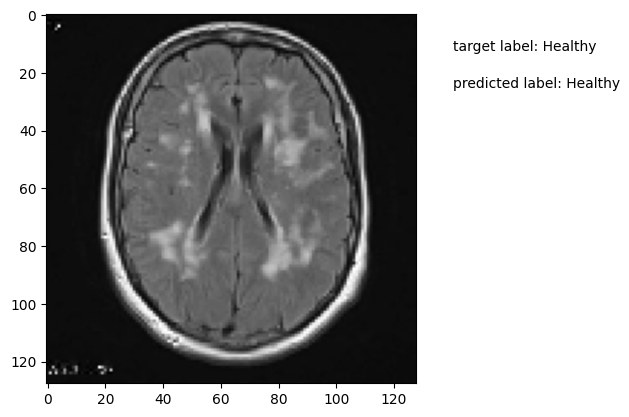

1/1 [==============================] - 0s 10ms/step


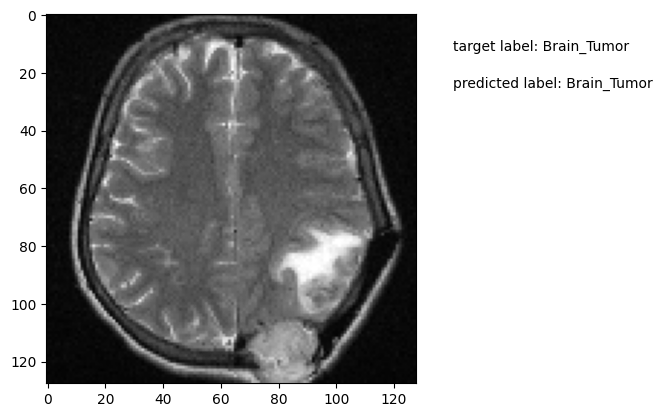

1/1 [==============================] - 0s 11ms/step


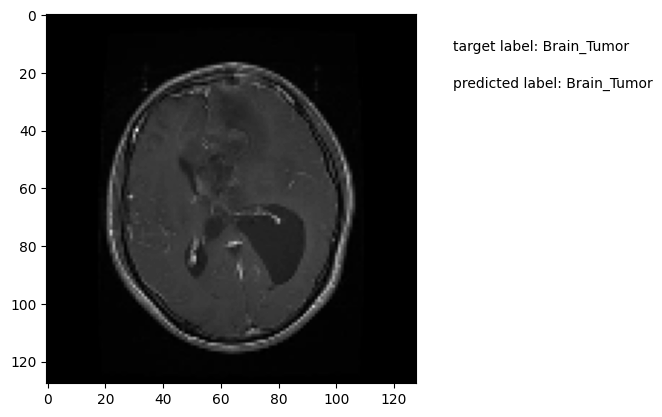

In [10]:
dir_It = gen.flow_from_directory('data/',
                                 target_size = (npixels,npixels),
                                 batch_size = 1,
                                 class_mode = 'binary',
                                 color_mode = 'grayscale',
                                 seed = 101)

for _ in range(3):
    img, label = dir_It.next()
    pred_lab = (int)(model.predict(img)>0.5)
    
    value = [i for i in classes if classes[i]==label][0]
    pred_value = [i for i in classes if classes[i]==pred_lab][0]
    
    plt.imshow(img[0],cmap='gray')
    plt.text(1.1,0.9,'target label: {}'.format(value),transform=plt.gca().transAxes)
    plt.text(1.1,0.8,'predicted label: {}'.format(pred_value),transform=plt.gca().transAxes)
    plt.show()

### Further model-performance evaluation

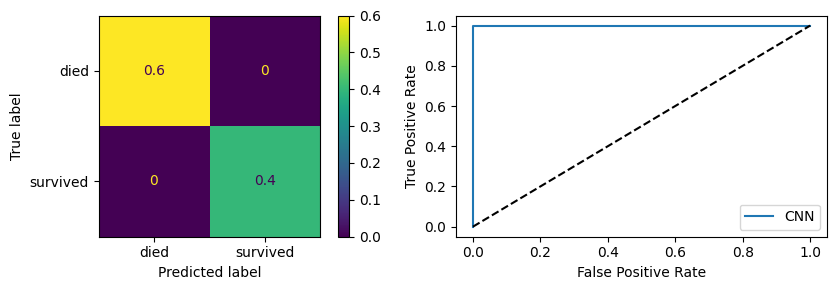

In [11]:
from sklearn.metrics import roc_curve, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

y_test, preds = [], []

for _ in range(len(test)):
    img, label = dir_It.next()
    
    pred_proba = model.predict(img,verbose=0)
    pred = (pred_proba>0.5).astype(int)
    
    preds.append((int)(pred[0]))
    y_test.append((int)(label[0]))

cm = confusion_matrix(y_test,preds,normalize='all')
fpr, tpr, thresh = roc_curve(y_test,preds)

fig,ax = plt.subplots(ncols=2,figsize=(9,3))
ConfusionMatrixDisplay(cm,display_labels=['died','survived']).plot(ax=ax[0])
nn_roc = RocCurveDisplay(fpr=fpr,tpr=tpr,estimator_name='CNN')
nn_roc.plot(ax=ax[1])
ax[1].plot([0,1],[0,1],color='black',ls='--')
plt.tight_layout()

In [12]:
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        69
           1       1.00      1.00      1.00        46

    accuracy                           1.00       115
   macro avg       1.00      1.00      1.00       115
weighted avg       1.00      1.00      1.00       115

